<a href="https://colab.research.google.com/github/SergeyBryukhanov/SergeyBryukhanov/blob/main/urok34_dz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Обучение U-net++ подобную архитектуры сегментировать легкие человека на радиографических снимках

In [ ]:
!pip install opendatasets

In [ ]:
import opendatasets as op
op.download("https://www.kaggle.com/datasets/tawsifurrahman/covid19-radiography-database/")

Skipping, found downloaded files in "./covid19-radiography-database" (use force=True to force download)


In [ ]:
import tensorflow as tf                                                               # библиотека Tensorflow
import keras                                                                          # библиотека Keras
from keras.layers import Input, Conv2D, MaxPooling2D, Activation, ReLU, Rescaling     # cлои библиотеки Keras
from keras.layers import BatchNormalization, Conv2DTranspose, Concatenate             # cлои библиотеки Keras
from keras.layers import Rescaling, Resizing                                          # cлои библиотеки Keras
from keras.models import Model, Sequential                                            # конструкторы построения моделей библиотеки Keras

from keras.optimizers import Adam                                                     # оптимизатор Adam
from keras.preprocessing.image import  load_img                                       # загрузка изображений
from keras.utils import to_categorical                                                # преобразует вектор класса (целые числа) в двоичную матрицу класса

import random                                                                         # генератор случайных чисел

import numpy as np                                                                    # библиотека линейной алгебры
import pandas as pd                                                                   # библиотека обработки табличных данных
import os                                                                             # библиотека работы с функциями операционной системы, в том числе с файлами
import albumentations as A                                                            # библиотека аугментации изображений (https://albumentations.ai/)

import matplotlib.pyplot as plt                                                       # библиотека для рисования графиков
%matplotlib inline

In [ ]:
dataset_path = './covid19-radiography-database/COVID-19_Radiography_Dataset/Normal'

image_dir = 'images'
label_dir = 'masks'

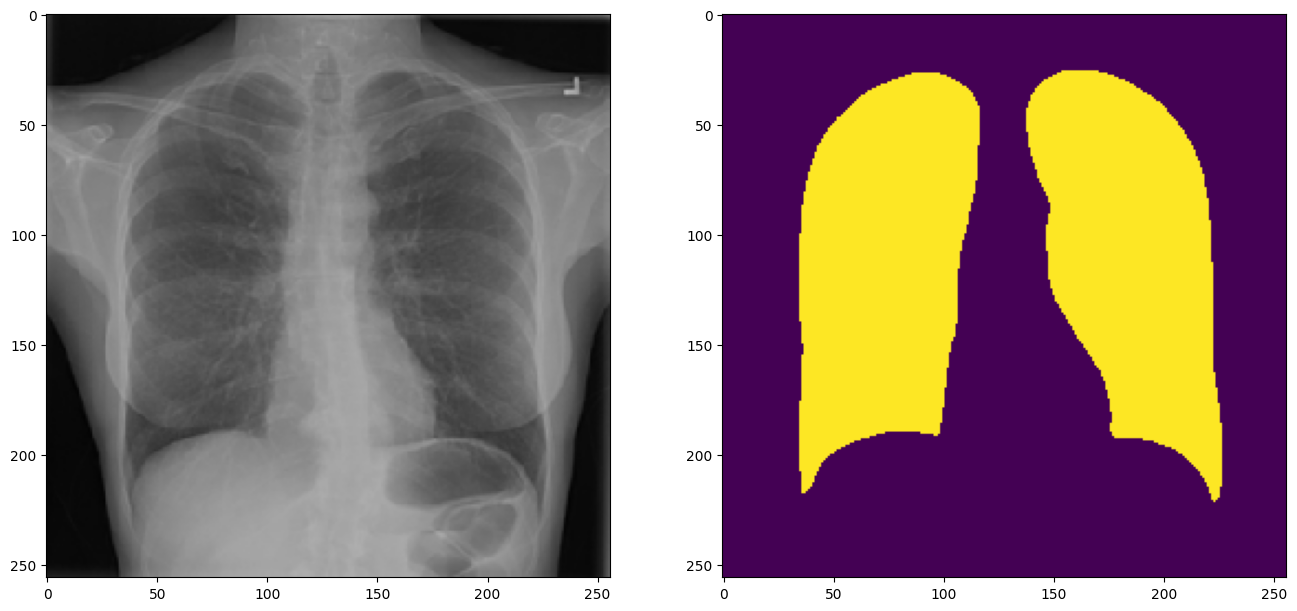

In [ ]:
original_image = os.path.join(dataset_path, image_dir, 'Normal-10007.png')       # путь до ориганального изображения
label_image_semantic = os.path.join(dataset_path, label_dir, 'Normal-10007.png') # путь до маски

fig, axs = plt.subplots(1, 2, figsize=(16, 8))                          # задаем область для построения (канвас)

img = np.array(load_img(original_image, target_size=(256, 256), color_mode='rgb'))   # загружаем оригинальное изображение как RGB с 3 каналами
mask = np.array(load_img(label_image_semantic, target_size=(256, 256), color_mode='grayscale'))  # загружаем маску как "отеннки серого", т.е. в один канал

axs[0].imshow(img)  # отрисовываем оригинальное изображение
axs[0].grid(False)

axs[1].imshow(mask) # отрисовываем маску (одноканальное изображение, каждый класс отображается как отдельный цвет)
axs[1].grid(False)

In [ ]:
input_img_path = sorted(
    [
        os.path.join(dataset_path, image_dir, fname)
        for fname in os.listdir(os.path.join(dataset_path, image_dir))
        if fname.endswith(".png")
    ]
)[:4000]

target_img_path = sorted(
    [
        os.path.join(dataset_path, label_dir, fname)
        for fname in os.listdir(os.path.join(dataset_path, label_dir))
        if fname.endswith(".png")
    ]
)[:4000]
# Определим batch_size равный 16.
# Как опеределили? Запустили обучение на 8, 16, 32 и посмотрели на точность обучения, скорость обучения и потребляемые ресурсы
# Наиболее оптимальным оказался вариант с размером пакета в 16 образцов
batch_size = 16
img_size = (256, 256)
NUM_CLASSES = 2

In [ ]:
class datasetGenerator(keras.utils.Sequence):
    def __init__(self, batch_size, img_size, input_img_path, target_img_path=None, validation=False):
        self.batch_size = batch_size
        self.img_size = img_size
        self.input_img_path = input_img_path
        self.target_img_path = target_img_path
        self.validation = validation

    def __len__(self):
        return len(self.target_img_path) // self.batch_size

    def __getitem__(self, idx):
        batch_input_img_path = self.input_img_path[idx*self.batch_size:(idx+1)*self.batch_size]
        batch_target_img_path = self.target_img_path[idx*self.batch_size:(idx+1)*self.batch_size]

        x = np.zeros((self.batch_size, *self.img_size, 1), dtype="float32")  # 1 канал для grayscale
        y = np.zeros((self.batch_size, *self.img_size, 1), dtype="float32")  # 1 канал для маски

        for i, (img_path, mask_path) in enumerate(zip(batch_input_img_path, batch_target_img_path)):
            # Загрузка изображения
            img = np.array(load_img(img_path, target_size=self.img_size, color_mode='grayscale'))

            # Загрузка и нормализация маски
            mask = np.array(load_img(mask_path, target_size=self.img_size, color_mode='grayscale'))
            mask = np.where(mask > 127, 1., 0.)  # Бинаризация + float32

            if not self.validation:
                transform = A.Compose([
                    A.HorizontalFlip(p=0.5),
                    A.VerticalFlip(p=0.5),
                ])
                transformed = transform(image=img, mask=mask)
                img = transformed["image"]
                mask = transformed["mask"]

            x[i] = np.expand_dims(img / 255.0, axis=-1)  # Нормализация + добавление канала
            y[i] = np.expand_dims(mask, axis=-1)  # Добавляем размерность канала

        return x, y

In [ ]:
import random

seed = 1523
random.Random(seed).shuffle(input_img_path)
random.Random(seed).shuffle(target_img_path)

In [ ]:
image_count = len(os.listdir(os.path.join(dataset_path, image_dir)))
val_samples = int(image_count * 0.15)

# Расщепим наш датасет  на обучающую и проверочные выборки
train_input_img_path = input_img_path[:-val_samples]
train_target_img_path = target_img_path[:-val_samples]
val_input_img_path = input_img_path[-val_samples:]
val_target_img_path = target_img_path[-val_samples:]

In [ ]:
train_gen = datasetGenerator(batch_size, img_size, train_input_img_path, train_target_img_path)

val_gen = datasetGenerator(batch_size, img_size, val_input_img_path, val_target_img_path, validation=True)

In [ ]:
def conv_block(x, filters, kernel_size=(3, 3), padding="same", activation="relu"):
    """Блок из двух сверточных слоев с BatchNorm и ReLU"""
    x = Conv2D(filters, kernel_size, padding=padding)(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    x = Conv2D(filters, kernel_size, padding=padding)(x)
    x = BatchNormalization()(x)
    x = Activation(activation)(x)
    return x

def create_unet_pp(input_shape=(256, 256, 1), deep_supervision=True):
    """Построение U-Net++"""
    inputs = Input(input_shape)

    # Энкодер (X0,0 -> X4,0)
    X0_0 = conv_block(inputs, 32)

    X1_0 = conv_block(MaxPooling2D()(X0_0), 64)
    X0_1 = conv_block(Conv2DTranspose(32, (2,2), strides=2)(X1_0), 32)
    X0_1 = Concatenate()([X0_0, X0_1])
    X0_1 = conv_block(X0_1, 32)

    X2_0 = conv_block(MaxPooling2D()(X1_0), 128)
    X1_1 = conv_block(Conv2DTranspose(64, (2,2), strides=2)(X2_0), 64)
    X1_1 = Concatenate()([X1_0, X1_1])
    X1_1 = conv_block(X1_1, 64)

    X0_2 = conv_block(Conv2DTranspose(32, (2,2), strides=2)(X1_1), 32)
    X0_2 = Concatenate()([X0_0, X0_1, X0_2])
    X0_2 = conv_block(X0_2, 32)

    X3_0 = conv_block(MaxPooling2D()(X2_0), 256)
    X2_1 = conv_block(Conv2DTranspose(128, (2,2), strides=2)(X3_0), 128)
    X2_1 = Concatenate()([X2_0, X2_1])
    X2_1 = conv_block(X2_1, 128)

    X1_2 = conv_block(Conv2DTranspose(64, (2,2), strides=2)(X2_1), 64)
    X1_2 = Concatenate()([X1_0, X1_1, X1_2])
    X1_2 = conv_block(X1_2, 64)

    X0_3 = conv_block(Conv2DTranspose(32, (2,2), strides=2)(X1_2), 32)
    X0_3 = Concatenate()([X0_0, X0_1, X0_2, X0_3])
    X0_3 = conv_block(X0_3, 32)

    # Центральный блок (X4,0)
    X4_0 = conv_block(MaxPooling2D()(X3_0), 512)

    # Декодер с плотными соединениями
    X3_1 = conv_block(Conv2DTranspose(256, (2,2), strides=2)(X4_0), 256)
    X3_1 = Concatenate()([X3_0, X3_1])
    X3_1 = conv_block(X3_1, 256)

    X2_2 = conv_block(Conv2DTranspose(128, (2,2), strides=2)(X3_1), 128)
    X2_2 = Concatenate()([X2_0, X2_1, X2_2])
    X2_2 = conv_block(X2_2, 128)

    X1_3 = conv_block(Conv2DTranspose(64, (2,2), strides=2)(X2_2), 64)
    X1_3 = Concatenate()([X1_0, X1_1, X1_2, X1_3])
    X1_3 = conv_block(X1_3, 64)

    X0_4 = conv_block(Conv2DTranspose(32, (2,2), strides=2)(X1_3), 32)
    X0_4 = Concatenate()([X0_0, X0_1, X0_2, X0_3, X0_4])
    X0_4 = conv_block(X0_4, 32)

    # Выходные слои с глубокой супервизией
    outputs = Conv2D(1, (1,1), activation='sigmoid')(X0_4)

    model = Model(inputs=inputs, outputs=outputs, name="UNetPlusPlus")
    return model

In [ ]:
# Создание и компиляция модели
model = create_unet_pp(input_shape=(256, 256, 1))
model.compile(optimizer=Adam(learning_rate=3e-4),
              loss='binary_crossentropy',
              metrics=['accuracy'])

callbacks = [
    keras.callbacks.ModelCheckpoint("segmentation.keras", monitor='val_loss', save_best_only=True)
]

In [ ]:
model.summary() # отчет о структуре модели

Model: "UNetPlusPlus"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_189 (Conv2D) │ (None, 256, 256,  │        320 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_189[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_186      │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_190 (Conv2D) │ (None, 256, 256,  │      9,248 │ activation_186[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_190[0][0]  │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_187      │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_16    │ (None, 128, 128,  │          0 │ activation_187[0… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_191 (Conv2D) │ (None, 128, 128,  │     18,496 │ max_pooling2d_16… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_191[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_188      │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_192 (Conv2D) │ (None, 128, 128,  │     36,928 │ activation_188[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_192[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_189      │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_17    │ (None, 64, 64,    │          0 │ activation_189[0… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_197 (Conv2D) │ (None, 64, 64,    │     73,856 │ max_pooling2d_17… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_197[0][0]

 Total params: 11,128,897 (42.45 MB)

 Trainable params: 11,118,273 (42.41 MB)

 Non-trainable params: 10,624 (41.50 KB)

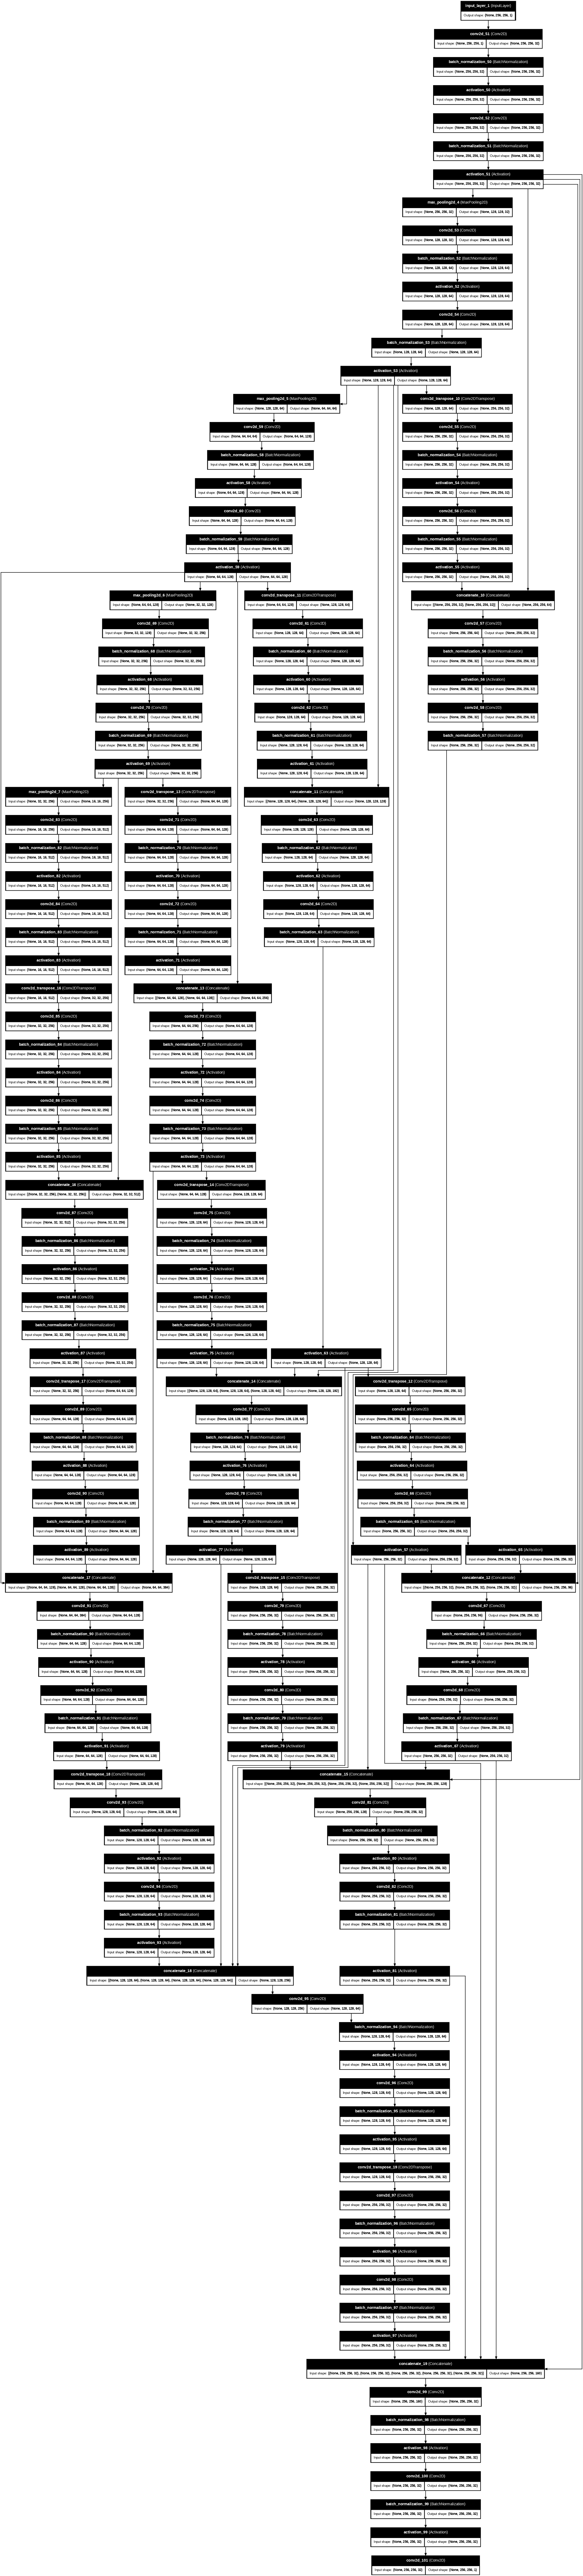

In [ ]:
# график структуры модели
tf.keras.utils.plot_model(model, "model.png", show_shapes=True, show_dtype=False, show_layer_names=True, rankdir='TB', expand_nested=False, dpi=70)

In [ ]:
epochs = 20
history = model.fit(train_gen,
                    validation_data=val_gen,
                    epochs=epochs,
                    batch_size=batch_size,
                    callbacks=callbacks
                   )

Epoch 1/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 267s 1s/step - accuracy: 0.8837 - loss: 0.3017 - val_accuracy: 0.7503 - val_loss: 0.5335
Epoch 2/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 225s 1s/step - accuracy: 0.9871 - loss: 0.0824 - val_accuracy: 0.8784 - val_loss: 0.3762
Epoch 3/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 218s 1s/step - accuracy: 0.9897 - loss: 0.0540 - val_accuracy: 0.9749 - val_loss: 0.0900
Epoch 4/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 218s 1s/step - accuracy: 0.9919 - loss: 0.0379 - val_accuracy: 0.9899 - val_loss: 0.0391
Epoch 5/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 217s 1s/step - accuracy: 0.9927 - loss: 0.0301 - val_accuracy: 0.9500 - val_loss: 0.1564
Epoch 6/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 217s 1s/step - accuracy: 0.9918 - loss: 0.0292 - val_accuracy: 0.9879 - val_loss: 0.0411
Epoch 7/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 217s 1s/step - accuracy: 0.9930 - loss: 0.0237 - val_accuracy: 0.9753 - val_loss: 0.0712
Epoch 8/20
154/154 ━━━━━━━━━━━━━━━━━━━━ 218s 1s/step - accuracy: 0.9925 - loss: 0.0236 - val_accu

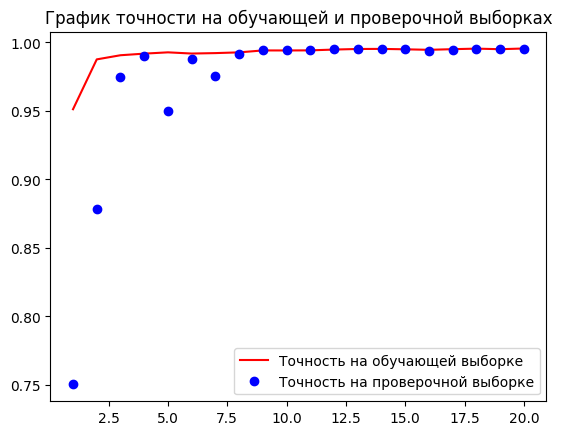

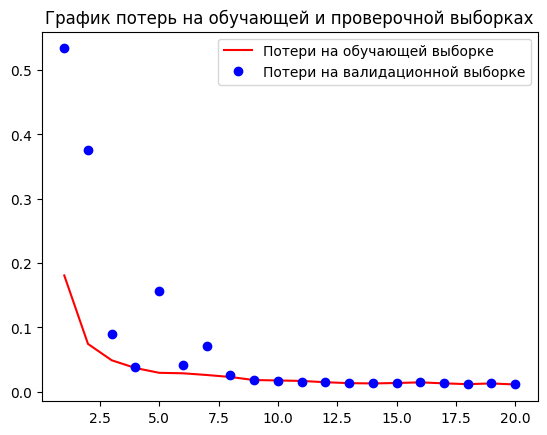

In [ ]:
acc = history.history['accuracy']                              # данные о точности на обучающей выборке
val_acc = history.history['val_accuracy']                      # данные о точности на проверочной выборке
loss = history.history['loss']                                             # данные об ошибке на обучающей выборке
val_loss = history.history['val_loss']                                     # данные об ошибке на проверочной выборке
epochs = range(1, len(acc) + 1)                                            # массив со значениями для оси абсцисс (Х)
plt.plot(epochs, acc, 'r', label='Точность на обучающей выборке')          #  строим график точность на обучающей выборке
plt.plot(epochs, val_acc, 'bo', label='Точность на проверочной выборке')   #  строим график точность на проверочной выборке
plt.title('График точности на обучающей и проверочной выборках')           #  заголовок графика
plt.legend()                                                               #  легенда графика
plt.figure()                                                               #  создаем новую фигуру (полотно для графика)
plt.plot(epochs, loss, 'r', label='Потери на обучающей выборке')           #  строим график потерь (ошибки) на обучающей выборке
plt.plot(epochs, val_loss, 'bo', label='Потери на валидационной выборке')  #  строим график потерь на проверочной выборке
plt.title('График потерь на обучающей и проверочной выборках')             #  заголовок графика
plt.legend()                                                               #  легенда графика
plt.show()

In [ ]:
input_img_path[-10:]


['./covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images/Normal-1559.png',
 './covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images/Normal-10187.png',
 './covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images/Normal-3380.png',
 './covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images/Normal-4023.png',
 './covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images/Normal-3245.png',
 './covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images/Normal-1723.png',
 './covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images/Normal-3954.png',
 './covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images/Normal-3509.png',
 './covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images/Normal-2424.png',
 './covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/images/Normal-147.png']

In [ ]:
def display_predictions(model, generator, num_samples=10):
    # Получаем один батч данных из генератора
    x_batch, y_batch = next(iter(generator))

    # Делаем предсказания
    preds = model.predict(x_batch[:num_samples])

    # Если preds имеет форму (batch, 256, 256, 1), сжимаем до (batch, 256, 256)
    if preds.ndim == 4 and preds.shape[-1] == 1:
        preds = np.squeeze(preds, axis=-1)

    plt.figure(figsize=(20, 6 * num_samples))

    for i in range(num_samples):
        # Оригинальное изображение
        plt.subplot(num_samples, 3, i*3 + 1)
        plt.imshow(x_batch[i].squeeze(), cmap='gray')
        plt.title(f"Original Image {i+1}")
        plt.axis('off')

        # Оригинальная маска
        plt.subplot(num_samples, 3, i*3 + 2)
        plt.imshow(y_batch[i].squeeze(), cmap='gray')
        plt.title(f"Original Mask {i+1}")
        plt.axis('off')

        # Предсказанная маска (с пороговой обработкой для бинарного вывода)
        plt.subplot(num_samples, 3, i*3 + 3)
        plt.imshow((preds[i] > 0.5).astype(np.float32), cmap='gray')
        plt.title(f"Predicted Mask {i+1}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step


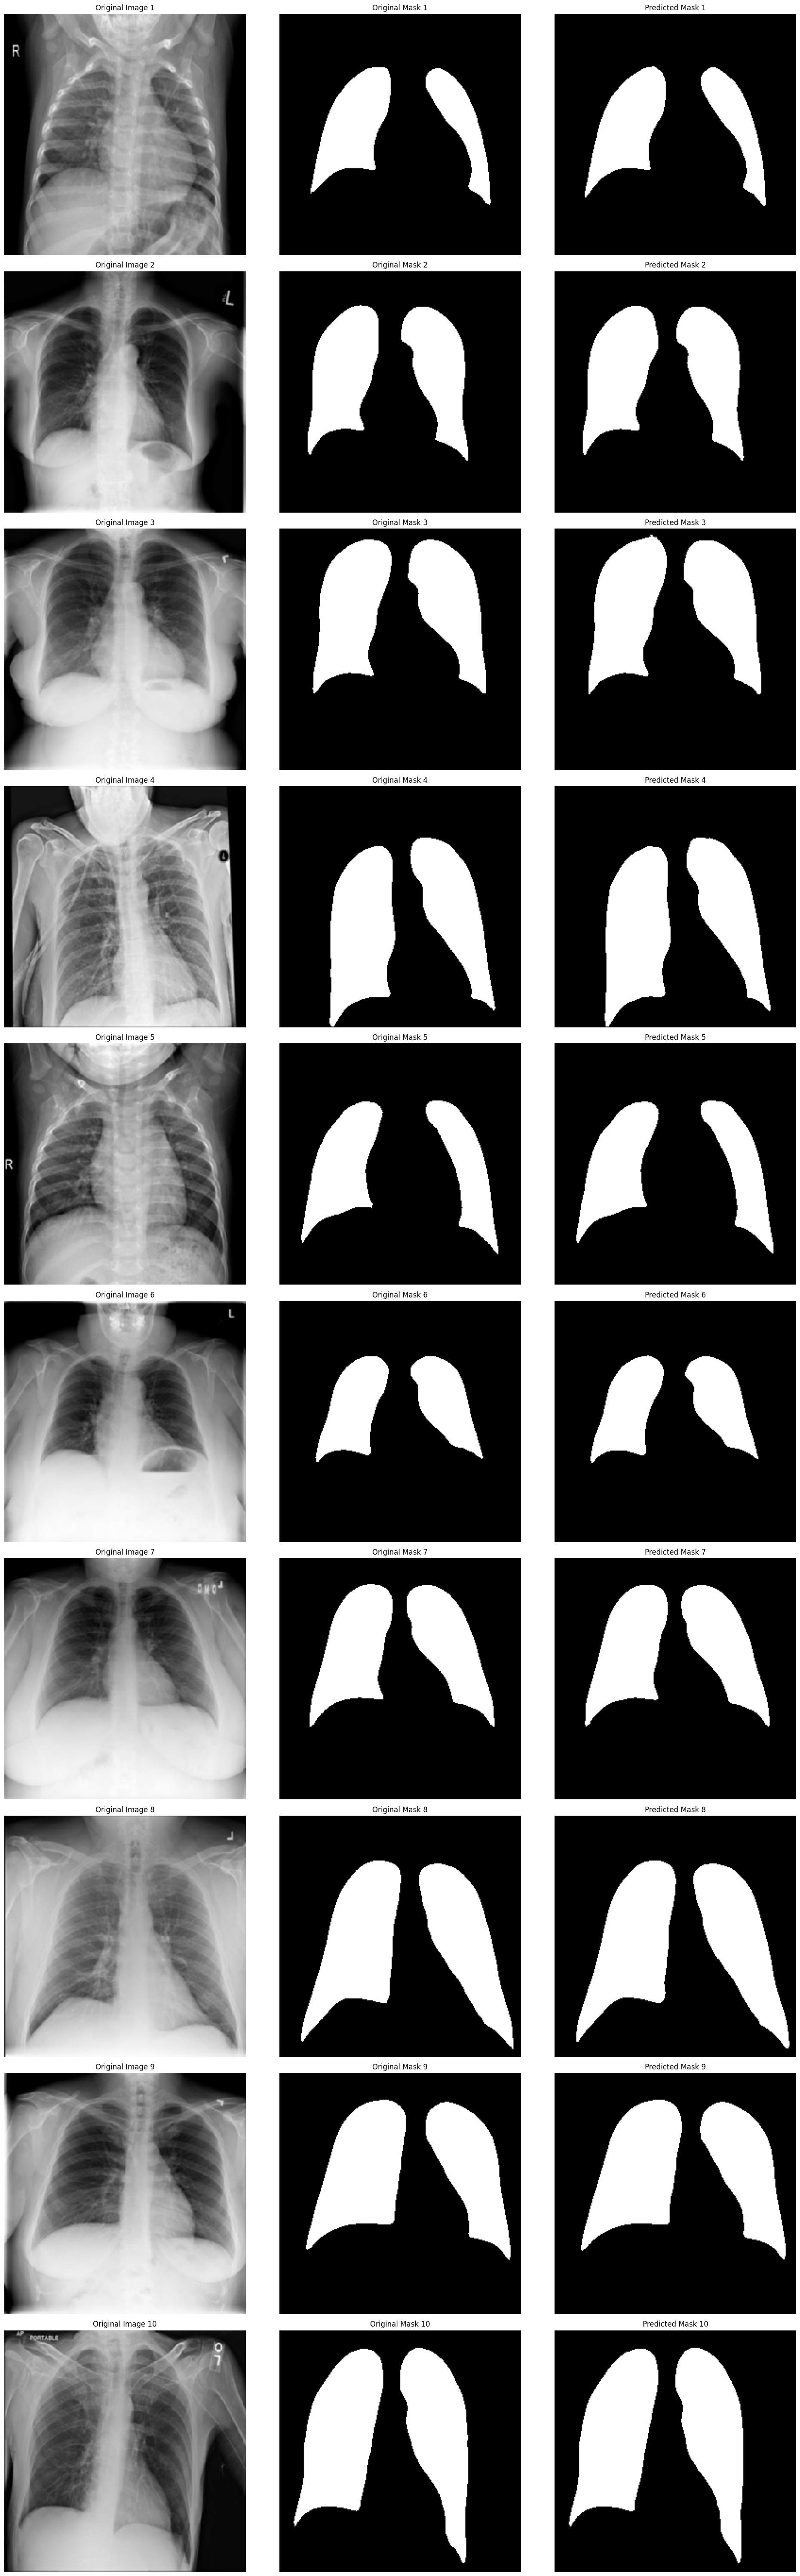

In [ ]:
display_predictions(model, val_gen, num_samples=10)